In [1]:
import timm
import copy
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, ConcatDataset, random_split

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class CNN_5Layer(nn.Module):
    def __init__(self):
        super(CNN_5Layer, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5),
        )

        dummy_input = torch.randn(1, 3, 224, 224)
        conv_output_size = self._get_conv_output_size(dummy_input)

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_output_size, 4, bias=True),
            nn.Softmax(dim=1)
        )

        self.l1_regularizer = nn.L1Loss()

    def _get_conv_output_size(self, x):
        with torch.no_grad():
            conv_output = self.conv_layers(x)
        return conv_output.view(x.size(0), -1).shape[1]

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [3]:
def create_model(model_name):
    if model_name == 'cnn-5-layer':
        model = CNN_5Layer()

    if model_name == 'vit-small': 
        model = timm.create_model('vit_small_patch16_224', pretrained=False, num_classes=4)
        
    if model_name == 'resnet-18': 
        model = timm.create_model('resnet18', pretrained=False, num_classes=4)

    return model

In [4]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

dataset = datasets.ImageFolder(root='../non-keyframes/energy_images', transform=transform)

class_datasets = {}
for i in range(len(dataset)):
    img, label = dataset[i]
    if label not in class_datasets:
        class_datasets[label] = []
    class_datasets[label].append(img)

oversampled_datasets = []
majority_class_len = max(len(class_datasets[label]) for label in class_datasets)
for label, data in class_datasets.items():
    if len(data) < majority_class_len:
        oversampled_data = resample(data,
                                    replace=True,
                                    n_samples=majority_class_len - len(data),
                                    random_state=0)
        class_datasets[label].extend(oversampled_data)
    oversampled_datasets.append(class_datasets[label])

oversampled_dataset = ConcatDataset([torch.utils.data.TensorDataset(torch.stack(images), torch.tensor([label]*len(images))) for label, images in enumerate(oversampled_datasets)])

total_size = len(oversampled_dataset)
train_size = int(total_size * 0.8) 
validation_size = int(total_size * 0.1) 
test_size = total_size - train_size - validation_size
generator = torch.Generator().manual_seed(0) 
train_dataset, validation_dataset, test_dataset = random_split(oversampled_dataset, [train_size, validation_size, test_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [5]:
model_name = 'vit-small'
model = create_model(model_name)

In [6]:
experiment = f'{model_name}-130-epochs-early-stopping-with-regularization-class-balanced'

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

num_epochs = 130  
patience = 20  
best_val_loss = float('inf')  
best_model = None  

train_loss_list = list()
val_loss_list = list()
train_accuracy_list = list()
val_accuracy_list = list()

for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    correct = 0
    total = 0
    print(f"Epoch {epoch+1}")

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)  

        optimizer.zero_grad()  
        outputs = model(images)  
        loss = criterion(outputs, labels)  
        loss.backward() 
        optimizer.step() 

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        print(f"Batch {batch_idx+1}, Loss: {loss.item():.6f}, Accuracy: {100 * correct / total:.2f}%")

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    print(f"Training - Epoch {epoch+1}, Loss: {train_loss:.6f}, Accuracy: {train_accuracy:.2f}%")

    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)

    # Validation step
    model.eval()  
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  
        for batch_idx, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)  

            outputs = model(images) 
            loss = criterion(outputs, labels) 

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            print(f"Validation Batch {batch_idx+1}, Loss: {loss.item():.6f}, Accuracy: {100 * val_correct / val_total:.2f}%")

    val_loss /= len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    print(f"Validation - Epoch {epoch+1}, Loss: {val_loss:.6f}, Accuracy: {val_accuracy:.2f}%")

    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        patience_counter = 0
    else:
        patience_counter += 1

    print(f'Patience—{patience_counter}')

    # Check for early stopping
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

model = best_model
torch.save(model.state_dict(), f'{experiment}-{model_name}.h5')

Using device: cuda:0
Epoch 1
Batch 1, Loss: 1.491522, Accuracy: 25.00%
Batch 2, Loss: 2.820446, Accuracy: 23.44%
Batch 3, Loss: 2.007741, Accuracy: 21.88%
Batch 4, Loss: 1.566374, Accuracy: 19.92%
Batch 5, Loss: 1.399680, Accuracy: 21.88%
Batch 6, Loss: 1.495968, Accuracy: 21.88%
Batch 7, Loss: 1.532898, Accuracy: 21.65%
Batch 8, Loss: 1.512199, Accuracy: 21.68%
Batch 9, Loss: 1.459816, Accuracy: 21.53%
Batch 10, Loss: 1.520188, Accuracy: 20.94%
Batch 11, Loss: 1.406206, Accuracy: 21.02%
Batch 12, Loss: 1.405356, Accuracy: 21.61%
Batch 13, Loss: 1.430234, Accuracy: 21.88%
Batch 14, Loss: 1.406982, Accuracy: 22.32%
Batch 15, Loss: 1.481178, Accuracy: 22.50%
Batch 16, Loss: 1.468680, Accuracy: 22.07%
Batch 17, Loss: 1.460581, Accuracy: 21.97%
Batch 18, Loss: 1.399694, Accuracy: 22.48%
Batch 19, Loss: 1.376845, Accuracy: 22.29%
Batch 20, Loss: 1.454780, Accuracy: 22.50%
Batch 21, Loss: 1.398436, Accuracy: 22.77%
Batch 22, Loss: 1.434833, Accuracy: 22.44%
Batch 23, Loss: 1.386279, Accuracy

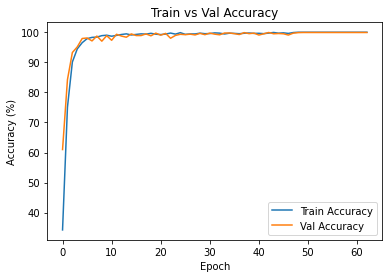

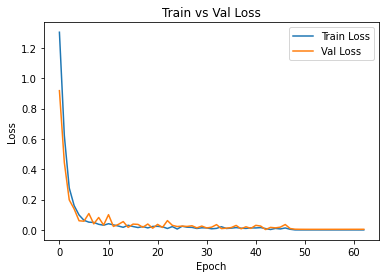

In [7]:
plt.plot(train_accuracy_list, label='Train Accuracy')

# Plotting the second graph
plt.plot(val_accuracy_list, label='Val Accuracy')

# Adding labels and a legend
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Val Accuracy')
plt.legend()

# Display the plot
plt.show()

plt.plot(train_loss_list, label='Train Loss')

# Plotting the second graph
plt.plot(val_loss_list, label='Val Loss')

# Adding labels and a legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Val Loss')
plt.legend()

# Display the plot
plt.show()

In [8]:
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        print(f"Test Batch {batch_idx+1}, Loss: {loss.item():.6f}, Accuracy: {100 * test_correct / test_total:.2f}%")

test_loss /= len(test_loader)
test_accuracy = 100 * test_correct / test_total

print(f"Test Set - Loss: {test_loss:.6f}, Accuracy: {test_accuracy:.2f}%")

cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

Test Batch 1, Loss: 0.001387, Accuracy: 100.00%
Test Batch 2, Loss: 0.000555, Accuracy: 100.00%
Test Batch 3, Loss: 0.000675, Accuracy: 100.00%
Test Batch 4, Loss: 0.000573, Accuracy: 100.00%
Test Batch 5, Loss: 0.000338, Accuracy: 100.00%
Test Batch 6, Loss: 0.000514, Accuracy: 100.00%
Test Batch 7, Loss: 0.000701, Accuracy: 100.00%
Test Batch 8, Loss: 0.000450, Accuracy: 100.00%
Test Batch 9, Loss: 0.000600, Accuracy: 100.00%
Test Batch 10, Loss: 0.000603, Accuracy: 100.00%
Test Batch 11, Loss: 0.000506, Accuracy: 100.00%
Test Batch 12, Loss: 0.000803, Accuracy: 100.00%
Test Batch 13, Loss: 0.001141, Accuracy: 100.00%
Test Batch 14, Loss: 0.001296, Accuracy: 100.00%
Test Batch 15, Loss: 0.002254, Accuracy: 100.00%
Test Batch 16, Loss: 0.001548, Accuracy: 100.00%
Test Batch 17, Loss: 0.005230, Accuracy: 100.00%
Test Batch 18, Loss: 0.004272, Accuracy: 100.00%
Test Batch 19, Loss: 0.001075, Accuracy: 100.00%
Test Batch 20, Loss: 0.024092, Accuracy: 99.92%
Test Batch 21, Loss: 0.002334,

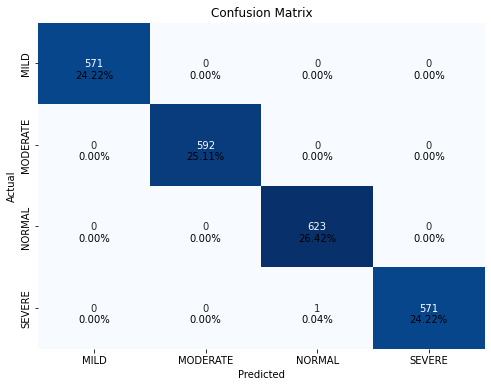

Accuracy: 1.00


In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

cm = confusion_matrix(all_labels, all_predictions)

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions)

# Calculate percentages for each element
cm_percentage = (cm / np.sum(cm)) * 100

# Plot confusion matrix with count and percentages
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['MILD', 'MODERATE', 'NORMAL', 'SEVERE'],
            yticklabels=['MILD', 'MODERATE', 'NORMAL', 'SEVERE'],
            ax=ax)

# Annotate each box with count and percentage
for i in range(len(cm)):
    for j in range(len(cm[0])):
        ax.text(j + 0.5, i + 0.5, f'\n\n{cm_percentage[i, j]:.2f}%',
                ha='center', va='center', color='black')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(f'Accuracy: {accuracy:.2f}')